In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

# TODO: Configure this model!
MODEL_NAME = "gpt-3.5-turbo"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


USER_AGENT environment variable not set, consider setting it to identify your requests.


### RUNNING DIFFERENT EXPERIMENTS

In [5]:
from langsmith import evaluate, Client
from tqdm.auto import tqdm

# Temporarily disable notebook bars
tqdm().disable = True

client = Client()
dataset_name = "PLANETS DATASET"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

0it [00:00, ?it/s]

View the evaluation results for experiment: 'gpt-4o-c9c0fd12' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/491699e2-c498-4c48-8898-3df8cd94da2d/compare?selectedSessions=4ae5bf85-068b-4782-b377-6f8fff831c61




15it [00:20,  1.39s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Which planet rotates on its side?,Uranus is the planet that rotates on its side.,None,Uranus rotates on its side with an axial tilt ...,1,1.376849,50a2efc9-1e85-4be6-a720-7bb4d677b560,c2b7c1ce-df13-4a1b-9771-fd6d0c70b2f0
1,Which planets are gas giants?,I don't know the answer to that question based...,None,Jupiter and Saturn are gas giants. They are co...,1,1.125074,54a0471b-6e1f-4012-b1a4-e77f6127bb1e,fdb0f315-daaf-4bad-9acf-c72547736bba
2,How many moons does Jupiter have?,I don't know the answer to your question.,None,"Jupiter has 95 known moons, including the four...",1,1.571677,64df96a4-516b-4c4c-9f2f-c734eddb6356,c6aa345d-69cf-4099-b834-a707ba438716
3,Which planet is closest to the Sun?,The planet closest to the Sun is Mercury.,None,"Mercury is the closest planet to the Sun, at a...",1,1.109593,847fd792-b15a-418b-b65c-54d28d792a73,6ce11920-3c0f-4eac-849f-e9ffae738a2c
4,Which planets are ice giants?,I don't know the answer to that question.,None,Uranus and Neptune are ice giants. They contai...,1,1.171818,8e88696e-1215-4f57-b175-92248e9b82c7,9b16ab68-29a9-4b2f-ad11-dd84f1e3c2da
5,What is Neptune known for?,I don't know.,None,Neptune is the farthest planet from the Sun an...,1,1.102460,90a1dc68-a978-4afb-8e29-111ef0685096,c225d217-9579-4d36-ba28-6018f583afa2
6,What is the largest planet?,I don't know the answer to that question.,None,Jupiter is the largest planet in the Solar Sys...,1,1.474807,978e4c1c-6383-4a5c-a5ed-977dfe8625fe,1c6ca524-85e6-4920-91a5-8046a905788c
7,Which planet is the hottest?,The hottest planet in our solar system is Venu...,None,Venus is the hottest planet with surface tempe...,1,1.102935,a37679cf-6fbd-4c32-8215-284df991a8d8,9d491c29-9f88-4058-b9a7-5d61013a7f15
8,Which planet has the Great Red Spot?,I don't know.,None,"Jupiter has the Great Red Spot, which is a per...",1,1.844132,be46212a-5313-488d-9403-9364f1a7147a,e7f8e8be-9423-4991-9741-13c9a453fdcd
9,What is special about Saturn?,I don't have information about Saturn in the p...,None,Saturn is best known for its spectacular ring ...,1,1.842768,c4ad80a4-6541-4cf0-b7d2-f5133a2ebd39,820531ac-1aab-48a4-b3e4-6aa462cbab8c


### Analysing the performance using a different llm model

In [6]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-a29fe609' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/491699e2-c498-4c48-8898-3df8cd94da2d/compare?selectedSessions=c1de6cb0-fa49-4454-a2f8-05fb3673f4a0




15it [00:20,  1.37s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Which planet rotates on its side?,"The planet Uranus rotates on its side, which m...",None,Uranus rotates on its side with an axial tilt ...,1,1.506250,50a2efc9-1e85-4be6-a720-7bb4d677b560,c43d296a-ba12-4fff-8c8f-e7be87fd6821
1,Which planets are gas giants?,I don't know the answer to that question based...,None,Jupiter and Saturn are gas giants. They are co...,1,1.158886,54a0471b-6e1f-4012-b1a4-e77f6127bb1e,3bb6cd23-036e-415a-b620-2c391643a15a
2,How many moons does Jupiter have?,I don't know the answer to that question.,None,"Jupiter has 95 known moons, including the four...",1,1.171531,64df96a4-516b-4c4c-9f2f-c734eddb6356,16e921b7-a90d-453d-867d-8cb8dab9bf8a
3,Which planet is closest to the Sun?,The planet closest to the Sun is Mercury.,None,"Mercury is the closest planet to the Sun, at a...",1,1.664576,847fd792-b15a-418b-b65c-54d28d792a73,6a1c2ec8-2718-4c0a-b086-fc915e017157
4,Which planets are ice giants?,I don't know the answer to that question.,None,Uranus and Neptune are ice giants. They contai...,1,1.150211,8e88696e-1215-4f57-b175-92248e9b82c7,21031969-c29e-4b38-b32d-2c7316efd656
5,What is Neptune known for?,I don't know what Neptune is known for.,None,Neptune is the farthest planet from the Sun an...,1,1.580905,90a1dc68-a978-4afb-8e29-111ef0685096,810fcb0e-ed1b-4719-851d-7ad3aa773d55
6,What is the largest planet?,The largest planet in our solar system is Jupi...,None,Jupiter is the largest planet in the Solar Sys...,1,1.286383,978e4c1c-6383-4a5c-a5ed-977dfe8625fe,e78e4b0a-694d-4478-aa4d-80bb8dcdb04d
7,Which planet is the hottest?,The hottest planet in our solar system is Venu...,None,Venus is the hottest planet with surface tempe...,1,1.777267,a37679cf-6fbd-4c32-8215-284df991a8d8,588e349c-efd4-4d77-977a-911fe7581a48
8,Which planet has the Great Red Spot?,I don't know the answer to that question.,None,"Jupiter has the Great Red Spot, which is a per...",1,1.229085,be46212a-5313-488d-9403-9364f1a7147a,8f69ee78-b954-4b03-aba5-f0c710aa290b
9,What is special about Saturn?,I don't know the specific details about what i...,None,Saturn is best known for its spectacular ring ...,1,1.120465,c4ad80a4-6541-4cf0-b7d2-f5133a2ebd39,89072069-dc1a-458d-bffe-9edae7ba781b


### RUNNING THE EXPERIMENT OVER A FEW EXAMPLES FROM OUR DATASET

In [7]:
evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name,
        example_ids=[   # We pass in a specific list of example_ids
            "978e4c1c-6383-4a5c-a5ed-977dfe8625fe",
            "be46212a-5313-488d-9403-9364f1a7147a"
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="two specific example ids"
)

View the evaluation results for experiment: 'two specific example ids-223703bb' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/491699e2-c498-4c48-8898-3df8cd94da2d/compare?selectedSessions=ee48f8c1-97c1-4f7c-a751-389cb457eaf7




2it [00:05,  2.56s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,What is the largest planet?,I don't know the answer to that question.,None,Jupiter is the largest planet in the Solar Sys...,1,1.413748,978e4c1c-6383-4a5c-a5ed-977dfe8625fe,26bcbf17-ff28-45ee-a0f2-f71e0a099d6a
1,Which planet has the Great Red Spot?,I don't know the answer to that question.,None,"Jupiter has the Great Red Spot, which is a per...",1,3.083534,be46212a-5313-488d-9403-9364f1a7147a,60c7bbdb-52a4-44f2-abf8-2b625e9910c3


### CONNCURENCY

In [8]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-61de9ee2' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/491699e2-c498-4c48-8898-3df8cd94da2d/compare?selectedSessions=f8f72768-3156-4db3-b2ee-7c1ff5c27c76




15it [00:07,  1.99it/s]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Which planets are gas giants?,I don't know the answer to that question based...,None,Jupiter and Saturn are gas giants. They are co...,1,1.534610,54a0471b-6e1f-4012-b1a4-e77f6127bb1e,eb4e34b2-c026-41a3-b074-2a8da202793b
1,How many moons does Jupiter have?,I don't know the answer to that question.,None,"Jupiter has 95 known moons, including the four...",1,1.829786,64df96a4-516b-4c4c-9f2f-c734eddb6356,715600c1-ca98-4847-9225-d223cbc372f2
2,Which planet rotates on its side?,Uranus is the planet that rotates on its side....,None,Uranus rotates on its side with an axial tilt ...,1,1.851238,50a2efc9-1e85-4be6-a720-7bb4d677b560,75a3ff14-9499-4c0f-8f39-784791b48a95
3,Which planet is closest to the Sun?,The planet closest to the Sun is Mercury.,None,"Mercury is the closest planet to the Sun, at a...",1,1.007856,847fd792-b15a-418b-b65c-54d28d792a73,d31cf593-98e8-49ae-a251-4495759759ab
4,Which planets are ice giants?,I don't know.,None,Uranus and Neptune are ice giants. They contai...,1,1.046428,8e88696e-1215-4f57-b175-92248e9b82c7,40e34dea-ce64-4b50-a1d3-3870c5007b07
5,What is Neptune known for?,I don't know.,None,Neptune is the farthest planet from the Sun an...,1,1.093958,90a1dc68-a978-4afb-8e29-111ef0685096,eaaf3a81-56f4-43bc-b537-16ec3db37842
6,What is the largest planet?,I don't know the answer to that question.,None,Jupiter is the largest planet in the Solar Sys...,1,1.169479,978e4c1c-6383-4a5c-a5ed-977dfe8625fe,b75cb7ef-fd04-403c-9acf-49f70901842a
7,Which planet is the hottest?,Venus is the hottest planet in our solar syste...,None,Venus is the hottest planet with surface tempe...,1,1.493314,a37679cf-6fbd-4c32-8215-284df991a8d8,b1ed72b9-16d9-4e86-8983-ba910b73229d
8,Which planet has the Great Red Spot?,I don't know the answer to the question about ...,None,"Jupiter has the Great Red Spot, which is a per...",1,1.625169,be46212a-5313-488d-9403-9364f1a7147a,3c995d77-8f10-425e-9440-eed410f3d773
9,What is special about Saturn?,I don't have information about Saturn in the p...,None,Saturn is best known for its spectacular ring ...,1,0.947966,c4ad80a4-6541-4cf0-b7d2-f5133a2ebd39,6e7c0b40-c2b7-4812-8289-8c9e75425c72


### HERES HOW MY LANGSMITH PORTAL LOOKS AFTER RUNNING ALL THESE EXPERIMENTS

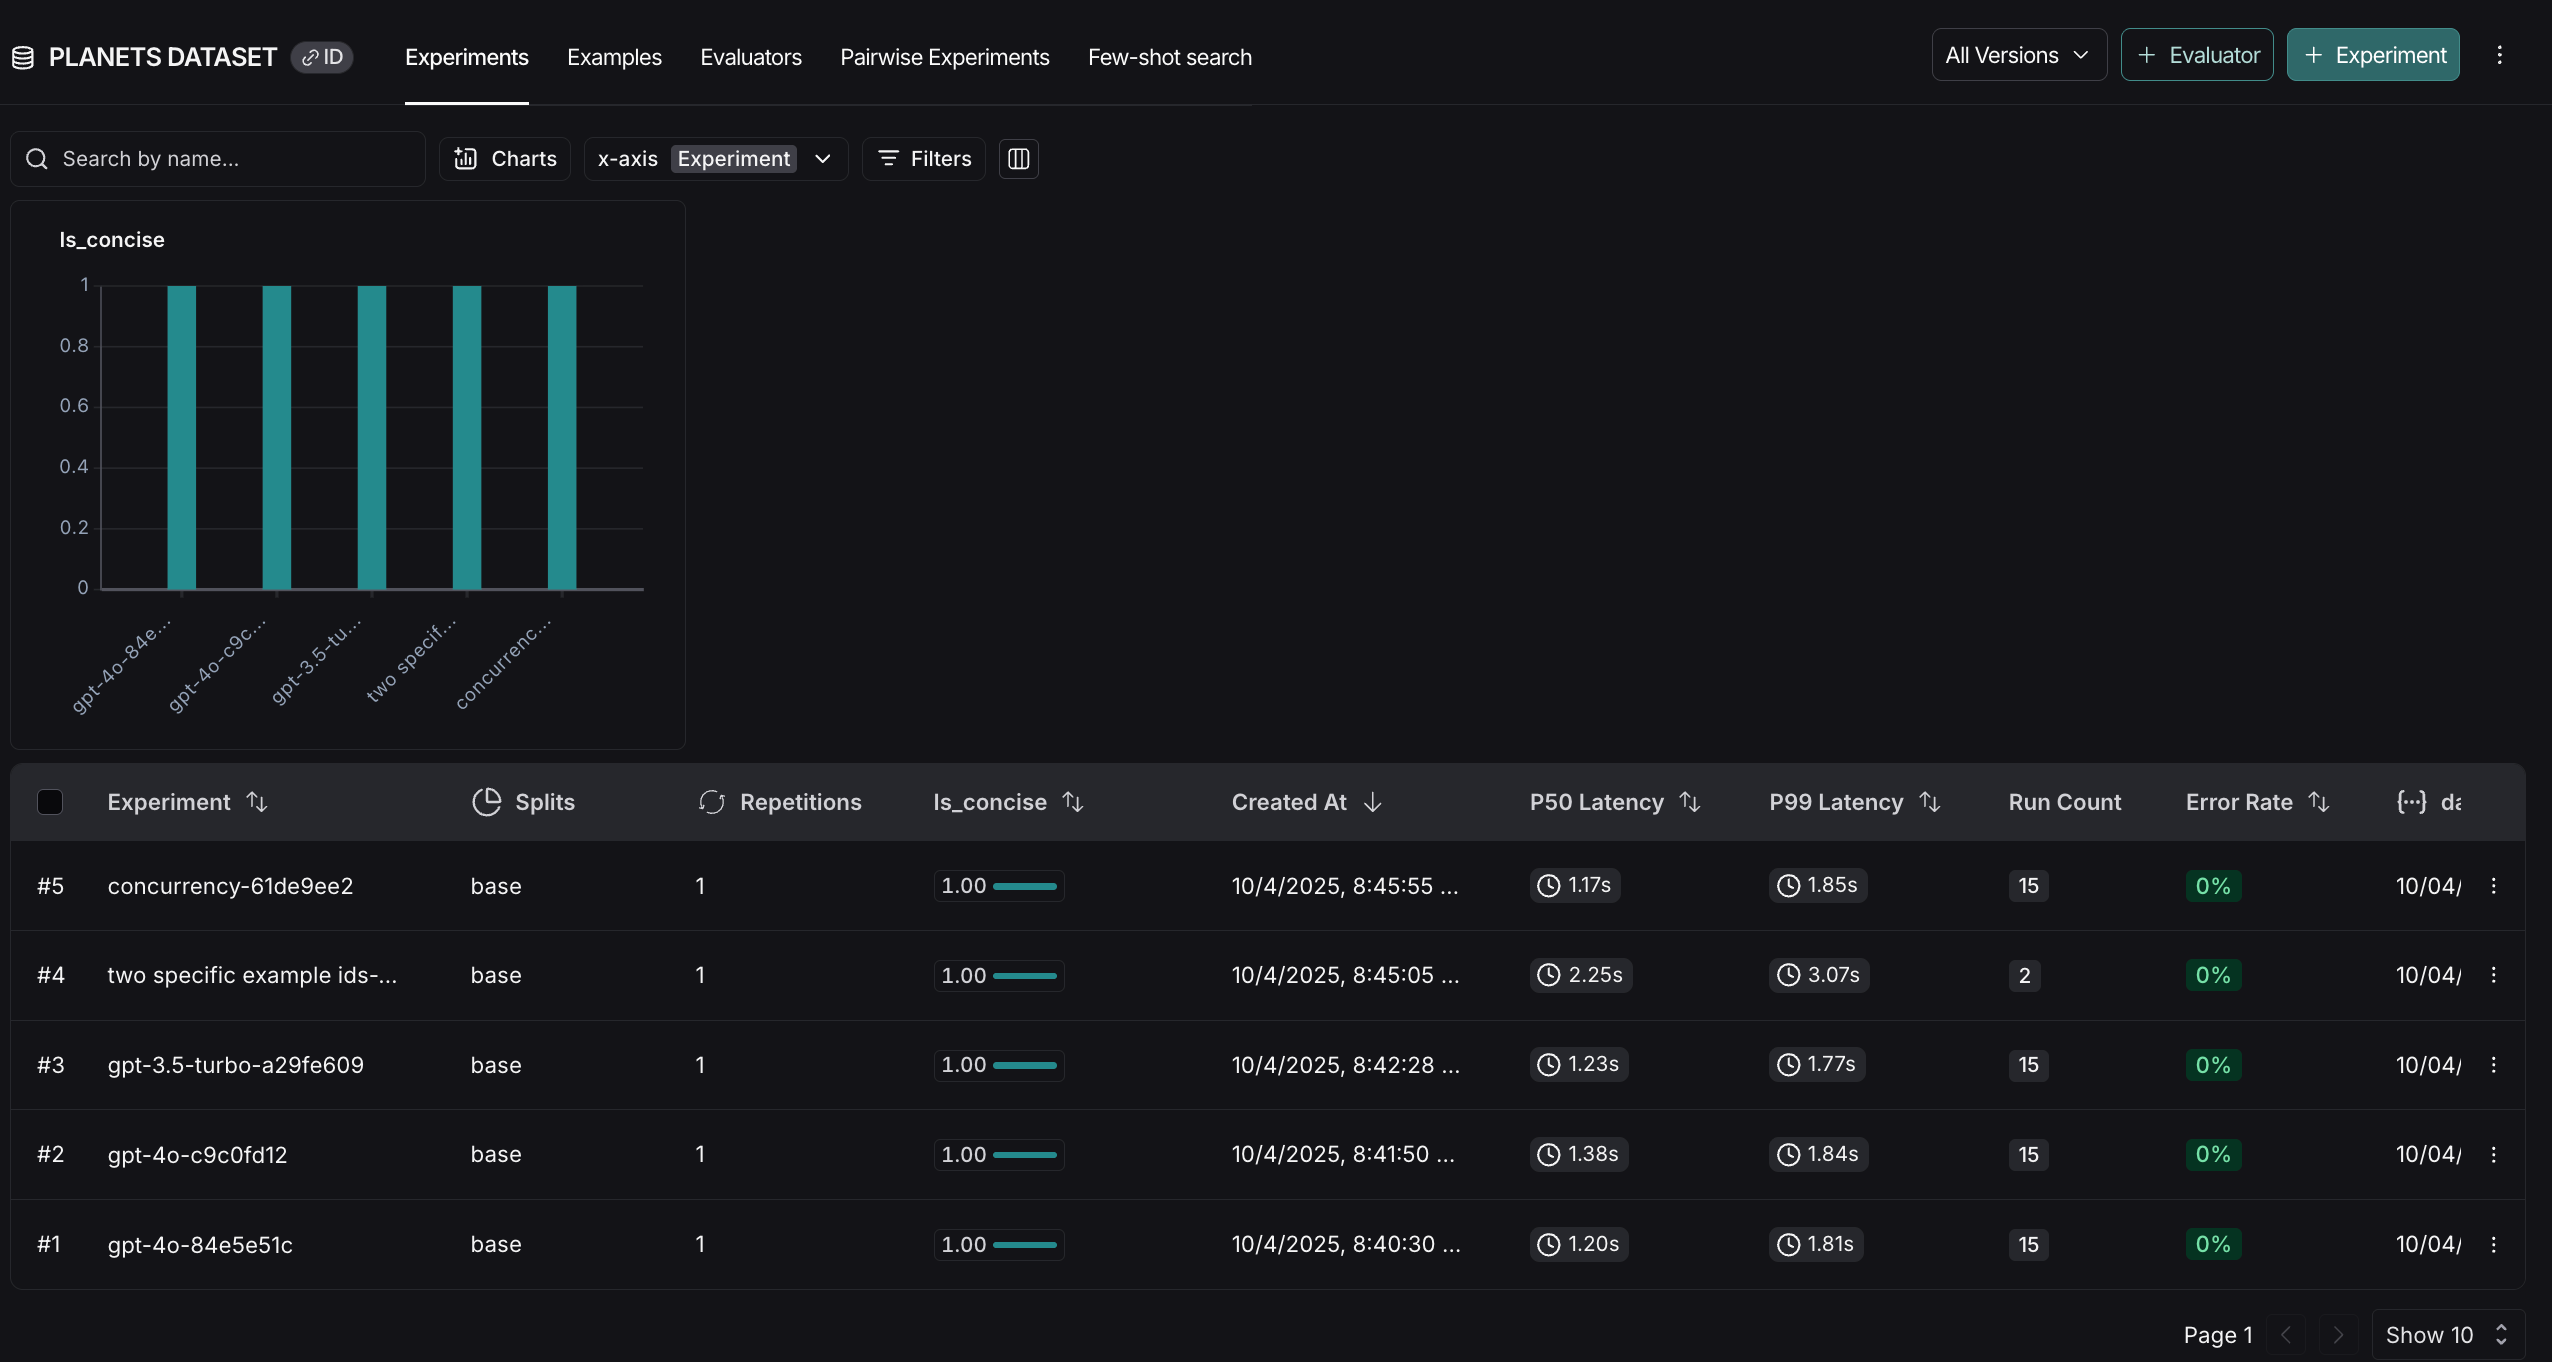